In [18]:
import pandas as pd

data = pd.read_csv('../../data/Raw-GPS-data-Kandy-Buses/MAIN/OUTPUT/merged_segements_10T.csv')
data_gps = pd.read_csv('../../data/Raw-GPS-data-Kandy-Buses/MAIN/OUTPUT/merged_gps_data_10T.csv')

grouped_data = data_gps['segment_id'].value_counts()

filtered_segment_ids = grouped_data[(grouped_data > 30) & (grouped_data < 50)].index.tolist()

filtered_data = data[data['segment_id'].isin(filtered_segment_ids)]
data = filtered_data


In [19]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def elbow_method(result,clustering_features):
  # eg :- clustering_features = ['speed_mean', 'speed_variance']
  X = result[clustering_features]

  # Standardize the data (important for K-Means)
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Initialize lists to store inertia values for different k
  inertia_values = []

  # Determine a range of k values to test (e.g., from 1 to 10 clusters)
  k_values = range(1, 11)

  # Calculate inertia for each k value
  for k in k_values:
      kmeans = KMeans(n_clusters=k, random_state=0,n_init=10)
      kmeans.fit(X_scaled)
      inertia_values.append(kmeans.inertia_)

  # Plot the elbow graph
  plt.plot(k_values, inertia_values, marker='o', linestyle='-')
  plt.xlabel('Number of Clusters (k)')
  plt.ylabel('Inertia')
  plt.title('Elbow Method for Optimal k')
  plt.grid(True)
  plt.show()

In [20]:
def bim_mean_smoothing(df,columns,data_per_bin):

    for index in range(len(columns)):
        data = df[columns[index]]
        # Specify the number of bins
        num_bins = round(len(data)/data_per_bin)
        # 5000

        # Dynamically calculate bin edges based on quantiles
        bin_edges = pd.qcut(data, q=num_bins, retbins=True, duplicates='drop')[1]
        bin_edges[0] = bin_edges[0]-1

        bin_labels = [f'Bin {i}' for i in range(1, len(bin_edges))]

        # Use cut to bin the data
        bin_name = "bin_name_"+columns[index]
        df[bin_name] = pd.cut(data, bins=bin_edges, labels=bin_labels)

        # Calculate bin means
        bin_means = df.groupby(bin_name)[columns[index]].mean()

        # Replace values with bin means
        new_col = 'bin_'+columns[index]
        df[new_col] = df[bin_name].map(bin_means)
        df = df.drop(bin_name, axis=1)

    return df

In [21]:
columns_used = ['ele_X_speed_acc_p', 'ele_X_speed_acc_n', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc', 'average_speed', 'max_speed', 'speed_variation']
data = data.dropna(subset=columns_used)
# elbow_method(data,['elevation_p', 'elevation_n', 'ele_X_speed_acc_p', 'ele_X_speed_acc_n', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc', 'stop_count', 'average_speed', 'max_speed', 'speed_variation'])

K means

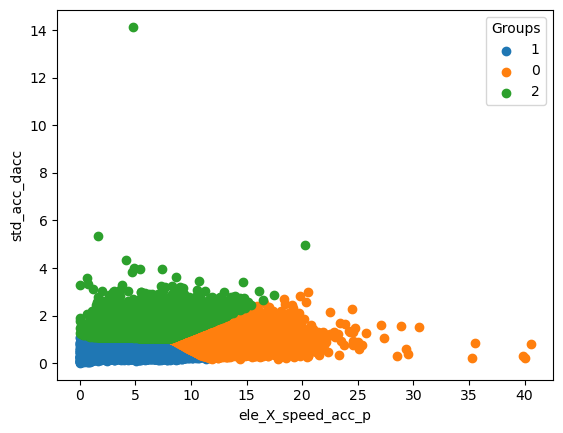

In [9]:
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data_kmean = data.copy()
# Select the features for clustering
X = data_kmean[['ele_X_speed_acc_p', 'std_acc_dacc']]

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering
k = 3  # You can choose the number of clusters (k) as needed
kmeans = KMeans(n_init=10,n_clusters=k, random_state=0)
data_kmean['cluster'] = kmeans.fit_predict(X_scaled)

# Add 'trip_id' back to the clustered data
# clustered_data = pd.merge(df_all, result[['trip_id', 'cluster']], on='trip_id')

# Create a scatter plot with annotations
groups = data_kmean['cluster'].unique()

for group in groups:
    group_data = data_kmean[data_kmean['cluster'] == group]
    plt.scatter(group_data['ele_X_speed_acc_p'], group_data['std_acc_dacc'], label=group)

plt.xlabel('ele_X_speed_acc_p')
plt.ylabel('std_acc_dacc')
plt.legend(title='Groups')

# Show the plot
plt.show()

Scaler + PCA

Explained Variance for PC1: 0.4829
Explained Variance for PC2: 0.1830
Explained Variance for PC3: 0.1526


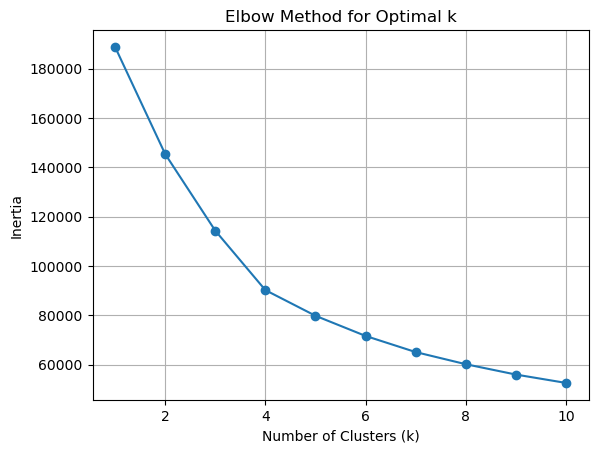

In [24]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

data = data.dropna(subset=columns_used)
pca_data = data.copy()
# Select the features for clustering
X = data[columns_used]

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(data=X_scaled, columns=columns_used)
# Apply PCA to reduce dimensionality
pca = PCA(n_components=3)  # Set the number of components as needed
principal_components = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each principal component
for i, ratio in enumerate(explained_variance_ratio, start=1):
    print(f"Explained Variance for PC{i}: {ratio:.4f}")

# Plot the cumulative explained variance
# cumulative_explained_variance = np.cumsum(explained_variance_ratio)
# print(cumulative_explained_variance)
# plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Cumulative Explained Variance for Principal Components')
# plt.show()


# principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3', 'PC4'])
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3'])

pca_data['PC1'] = principal_df['PC1']
pca_data['PC2'] = principal_df['PC2']
pca_data['PC3'] = principal_df['PC3']
# pca_data['PC4'] = principal_df['PC4']

elbow_method(principal_df,['PC1', 'PC2','PC3'])
# X_scaled_df

K means After PCA

In [61]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

principal_df_copy = principal_df.copy()
principal_components_copy = principal_components.copy()
pca_data_copy = pca_data.copy()

# Perform K-Means clustering
k = 4  # You can choose the number of clusters (k) as needed
kmeans = KMeans(n_init=10,n_clusters=k, random_state=0)
pca_data_copy['cluster'] = kmeans.fit_predict(principal_components_copy)

pca_data_copy=pca_data_copy.reset_index(drop=True)
principal_df_copy=principal_df_copy.reset_index(drop=True)

# Fit K-Means on the principal components
principal_df_copy['cluster'] = pca_data_copy['cluster']

principal_df_copy = principal_df_copy[(principal_df_copy['PC2'] < 10) & (principal_df_copy['PC1'] < 10) & (principal_df_copy['PC3'] < 10)]

centers = kmeans.cluster_centers_
pca_data_copy
# # Plot the clusters in the reduced space
# plt.scatter(principal_df_copy['PC1'], principal_df_copy['PC2'],principal_df_copy['PC3'], c=principal_df_copy['cluster'], cmap='viridis', marker='o', s=50, edgecolors='k')
# plt.title('PCA + K-Means Clustering')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

# # Create a 3D scatter plot
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Scatter plot in 3D
# scatter = ax.scatter(
#     principal_df_copy['PC1'],
#     principal_df_copy['PC2'],
#     principal_df_copy['PC3'],
#     c=principal_df_copy['cluster'],
#     cmap='viridis',
#     marker='o',
#     s=50,
#     edgecolors='k'
# )

# # Add labels and title
# ax.set_xlabel('Principal Component 1')
# ax.set_ylabel('Principal Component 2')
# ax.set_zlabel('Principal Component 3')
# ax.set_title('PCA + K-Means Clustering')

# # Add color bar
# cbar = fig.colorbar(scatter)
# cbar.set_label('Cluster')

# # Show the plot
# plt.show()


# Calculate Silhouette Score
# silhouette_avg = silhouette_score(principal_components_copy, pca_data_copy['cluster'])

# print(f"For k={3}, Silhouette Score: {silhouette_avg}")

# # Calculate Davies-Bouldin Index
# db_index = davies_bouldin_score(principal_components_copy, pca_data_copy['cluster'])

# print(f"For k={3}, Davies-Bouldin Index: {db_index}")

# pca_data_copy.head()

# pca_data_copy.to_csv('PCA-3_K-4_speed.csv', index=False)
# columns_used.append("cluster")
# pca_data_copy[columns_used+["segment_id","cluster"]][pca_data_copy["cluster"]==0].head(5)


,segment_starting_time,segment_ending_time,trip_id,deviceid,date,start_terminal,end_terminal,direction,day_of_week,hour_of_day,...,ele_X_speed_acc_p,ele_X_speed_acc_n,average_acceleration,average_deacceleration,std_acc_dacc,stop_count,PC1,PC2,PC3,cluster
0,2021-10-16 07:08:31,2021-10-16 07:18:31,1.0,116,2021-10-16,BT02,BT01,2,5,7,...,5.618765,15.764998,0.603900,-1.230988,1.021837,4,5.186926,-2.529258,-1.727694,1
1,2021-10-16 07:18:31,2021-10-16 07:28:31,1.0,116,2021-10-16,BT02,BT01,2,5,7,...,10.944814,8.906415,0.442037,-0.663055,0.759768,4,1.262283,-2.011966,0.520740,2
2,2021-10-16 07:28:31,2021-10-16 07:38:31,1.0,116,2021-10-16,BT02,BT01,2,5,7,...,6.122113,10.405097,0.434465,-0.626983,0.648791,7,-0.130129,-1.138353,-0.933326,3
3,2021-10-16 07:38:31,2021-10-16 07:48:31,1.0,116,2021-10-16,BT02,BT01,2,5,7,...,13.899388,5.383102,0.335428,-0.522203,0.525860,2,-0.234426,-2.234896,1.678583,2
4,2021-10-16 08:03:04,2021-10-16 08:13:04,2.0,116,2021-10-16,BT01,BT02,1,5,8,...,8.178763,6.384049,0.232393,-0.189459,0.258183,2,-1.109983,-0.860257,-2.128928,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62926,2022-11-01 17:40:45,2022-11-01 17:50:45,17196.0,1377,2022-11-01,BT02,BT01,2,1,17,...,2.132789,13.674759,0.692656,-1.017781,0.930507,4,NaN,NaN,NaN,1
62927,2022-11-01 17:50:45,2022-11-01 18:00:45,17196.0,1377,2022-11-01,BT02,BT01,2,1,17,...,3.920629,4.453990,0.314501,-0.395969,0.380585,7,NaN,NaN,NaN,0
62928,2022-11-01 18:00:45,2022-11-01 18:10:45,17196.0,1377,2022-11-01,BT02,BT01,2,1,17,...,10.427524,5.506391,0.227436,-0.370256,0.372329,4,NaN,NaN,NaN,0
62929,2022-11-01 18:10:45,2022-11-01 18:20:45,17196.0,1377,2022-11-01,BT02,BT01,2,1,17,...,11.319730,11.701036,0.358782,-0.465714,0.512172,4,NaN,NaN,NaN,3


Score System (Drivers)

In [60]:
def ScoreDriver(deviceid):
    filtered_df = pca_data_copy[pca_data_copy['deviceid'] == deviceid]
    cluster_counts = filtered_df['cluster'].value_counts().reset_index()
    cluster_counts.columns = ['cluster', 'count']
    cluster_scores = {0: 100, 1: 80, 2: 20, 3: 10}
    weighted_score = (cluster_counts.apply(lambda row: cluster_scores.get(row['cluster'], 0) * row['count'], axis=1).sum() / sum(cluster_counts['count']))
    return weighted_score.round(2)
    # print(f"Device Score: {weighted_score:.2f} out of 100")

def getScoresOfDrivers():
    unique_device_ids = pca_data_copy['deviceid'].unique()

    output = {
        'deviceid' : [],
        'score' : [],
        'scaledScores' : []
    }

    for deviceId in unique_device_ids:
        score = ScoreDriver(deviceId)
        output['deviceid'].append(deviceId)
        output['score'].append(score)

    min_val = min(output['score'])
    max_val = max(output['score'])

    scaledScore = [((x - min_val) / (max_val - min_val) * 100).round(2) for x in output['score']]

    output['scaledScores'] = scaledScore
    # print(output)
    return output 

getScoresOfDrivers()

{'deviceid': [116, 117, 123, 128, 262, 264, 274, 279, 294, 505, 513, 1143, 1358, 1377, 250, 550, 1410, 121, 209, 275, 1408, 1409, 1718, 1719, 1166, 284], 'score': [52.25, 47.96, 50.52, 53.4, 52.92, 49.49, 50.39, 52.38, 49.01, 47.8, 47.88, 47.29, 47.44, 46.78, 48.95, 44.6, 42.13, 53.9, 42.94, 47.66, 45.28, 18.24, 32.86, 41.0, 57.63, 56.67], 'scaledScores': [86.34, 75.45, 81.95, 89.26, 88.04, 79.33, 81.62, 86.67, 78.12, 75.04, 75.25, 73.75, 74.13, 72.45, 77.96, 66.92, 60.65, 90.53, 62.71, 74.69, 68.65, 0.0, 37.12, 57.78, 100.0, 97.56]}


{'deviceid': [116,
  117,
  123,
  128,
  262,
  264,
  274,
  279,
  294,
  505,
  513,
  1143,
  1358,
  1377,
  250,
  550,
  1410,
  121,
  209,
  275,
  1408,
  1409,
  1718,
  1719,
  1166,
  284],
 'score': [52.25,
  47.96,
  50.52,
  53.4,
  52.92,
  49.49,
  50.39,
  52.38,
  49.01,
  47.8,
  47.88,
  47.29,
  47.44,
  46.78,
  48.95,
  44.6,
  42.13,
  53.9,
  42.94,
  47.66,
  45.28,
  18.24,
  32.86,
  41.0,
  57.63,
  56.67],
 'scaledScores': [86.34,
  75.45,
  81.95,
  89.26,
  88.04,
  79.33,
  81.62,
  86.67,
  78.12,
  75.04,
  75.25,
  73.75,
  74.13,
  72.45,
  77.96,
  66.92,
  60.65,
  90.53,
  62.71,
  74.69,
  68.65,
  0.0,
  37.12,
  57.78,
  100.0,
  97.56]}

Score System (Trips)

In [71]:
def ScoreTrip(deviceid,trip_id):
    filtered_df = pca_data_copy[(pca_data_copy['trip_id'] == trip_id) & (pca_data_copy['deviceid'] == deviceid)]
    cluster_counts = filtered_df['cluster'].value_counts().reset_index()
    cluster_counts.columns = ['cluster', 'count']
    cluster_scores = {0: 100, 1: 80, 2: 20, 3: 10}
    weighted_score = (cluster_counts.apply(lambda row: cluster_scores.get(row['cluster'], 0) * row['count'], axis=1).sum() / sum(cluster_counts['count']))
    return weighted_score.round(2)
  
    # print(f"Device Score: {weighted_score:.2f} out of 100")

def getScoresOfTrips(deviceid):
    unique_trip_ids = pca_data_copy[pca_data_copy['deviceid'] == deviceid]['trip_id'].unique()

    output = {
        'trip_id' : [],
        'score' : [],
        'scaledScores' : []
    }

    for trip_id in unique_trip_ids:
        score = ScoreTrip(deviceid,trip_id)
        output['trip_id'].append(trip_id)
        output['score'].append(score)

    min_val = min(output['score'])
    max_val = max(output['score'])

    scaledScore = [((x - min_val) / (max_val - min_val) * 100).round(2) for x in output['score']]

    output['scaledScores'] = scaledScore
    return output 

getScoresOfTrips(116)

{'trip_id': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 1707.0, 1708.0, 1709.0, 1710.0, 1711.0, 1712.0, 1713.0, 1714.0, 1715.0, 1716.0, 1717.0, 1718.0, 1719.0, 1720.0, 1721.0, 1722.0, 1723.0, 1724.0, 1725.0, 1726.0, 1727.0, 1728.0, 1729.0, 1730.0, 1731.0, 1732.0, 1733.0, 1734.0, 1735.0, 1736.0, 1737.0, 1738.0, 1739.0, 1740.0, 1741.0, 1742.0, 1743.0, 1744.0, 1745.0, 1746.0, 1747.0, 1748.0, 1749.0, 1750.0, 1751.0, 1752.0, 1753.0, 1754.0, 1755.0, 1756.0, 1757.0, 1758.0, 1759.0, 1760.0, 1761.0, 1762.0, 1763.0, 1764.0, 1765.0, 1766.0, 1767.0

{'trip_id': [1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  7.0,
  8.0,
  9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  14.0,
  15.0,
  16.0,
  17.0,
  18.0,
  19.0,
  20.0,
  21.0,
  22.0,
  23.0,
  24.0,
  25.0,
  26.0,
  27.0,
  28.0,
  29.0,
  30.0,
  31.0,
  32.0,
  33.0,
  34.0,
  35.0,
  36.0,
  37.0,
  38.0,
  39.0,
  40.0,
  41.0,
  42.0,
  43.0,
  44.0,
  45.0,
  46.0,
  47.0,
  48.0,
  49.0,
  50.0,
  51.0,
  52.0,
  53.0,
  54.0,
  55.0,
  56.0,
  57.0,
  58.0,
  59.0,
  60.0,
  61.0,
  62.0,
  63.0,
  64.0,
  65.0,
  66.0,
  67.0,
  68.0,
  69.0,
  70.0,
  71.0,
  72.0,
  73.0,
  74.0,
  75.0,
  76.0,
  77.0,
  78.0,
  79.0,
  80.0,
  81.0,
  82.0,
  83.0,
  84.0,
  85.0,
  1707.0,
  1708.0,
  1709.0,
  1710.0,
  1711.0,
  1712.0,
  1713.0,
  1714.0,
  1715.0,
  1716.0,
  1717.0,
  1718.0,
  1719.0,
  1720.0,
  1721.0,
  1722.0,
  1723.0,
  1724.0,
  1725.0,
  1726.0,
  1727.0,
  1728.0,
  1729.0,
  1730.0,
  1731.0,
  1732.0,
  1733.0,
  1734.0,
  1735.0,
  1736.0,
  1737.0,
  1738.0

In [38]:
# Sample input data for one device ID
data = {'cluster_id': [2, 0, 3, 1],
        'count': [1154, 10081, 860, 270]}
df = pd.DataFrame(data)

# Define a scoring system
cluster_scores = {0: 100, 1: 80, 2: 60, 3: 40}

# Calculate the total count in good clusters (0 and 1)
good_clusters_count = df[df['cluster'].isin([0, 1])]['count'].sum()

# Calculate the weighted score based on the counts in good clusters
weighted_score = (df.apply(lambda row: cluster_scores.get(row['cluster_id'], 0) * row['count'], axis=1).sum() / sum(data['count']))

print(f"Device Score: {weighted_score:.2f} out of 100")

Device Score: 91.66 out of 100


Variance or Standard Deviation

In [188]:
import numpy as np

feature_names = columns_used
n_clusters = np.max(pca_data_copy['cluster']) + 1

def calculate_feature_statistics(data, labels, statistic="std"):
    num_clusters = np.max(labels) + 1
    feature_statistics_per_cluster = []

    for cluster in range(num_clusters):
        cluster_indices = np.where(labels == cluster)[0]
        cluster_data = data.iloc[cluster_indices]

        # Calculate variance or standard deviation for each feature
        if statistic == "std":
            feature_statistics = np.std(cluster_data, axis=0)
        elif statistic == "var":
            feature_statistics = np.var(cluster_data, axis=0)
        else:
            raise ValueError("Invalid statistic. Use 'std' or 'var'.")

        feature_statistics_per_cluster.append(feature_statistics)

    return feature_statistics_per_cluster

# Calculate standard deviation for each feature within clusters
std_per_feature = calculate_feature_statistics(X_scaled_df[columns_used], pca_data_copy['cluster'], statistic="std")

# Calculate variance for each feature within clusters
# var_per_feature = calculate_feature_statistics(X, labels, statistic="var")

# Create a DataFrame to display the results

cluster_names = [f"Cluster {i+1}" for i in range(n_clusters)]
std_df = pd.DataFrame(np.array(std_per_feature).T, columns=cluster_names, index=feature_names)
# var_df = pd.DataFrame(np.array(var_per_feature).T, columns=cluster_names, index=feature_names)

std_df.to_csv('kmeans_clusters_feature_std.csv', index=True)

# Print the results
print("Standard Deviation:")
std_df


FileNotFoundError: [Errno 2] No such file or directory: 'kmeans_clusters_feature_std.csv'

Data Smoothing (Binning Mean)

In [ ]:
smoothed_data = bim_mean_smoothing(pca_data_copy,columns_used,6000)
smoothed_data.head()

In [ ]:
elbow_method(smoothed_data,["PC1","PC2"])

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score


# data = data.dropna(subset=['elevation_p', 'elevation_n', 'ele_X_speed_acc_p', 'ele_X_speed_acc_n', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc', 'stop_count', 'average_speed', 'max_speed', 'speed_variation'])

smoothed_data_copy = smoothed_data.copy()
# Select the features for clustering
X = smoothed_data_copy[['bin_ele_X_speed_acc_p', 'bin_ele_X_speed_acc_n','bin_std_acc_dacc', 'bin_speed_variation','bin_average_speed']]


# 'ele_X_speed_acc_p', 'ele_X_speed_acc_n', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc', 'speed_variation','average_speed', 'max_speed'

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Set the number of components as needed
smoothed_principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
smoothed_principal_df = pd.DataFrame(data=smoothed_principal_components, columns=['PC1', 'PC2'])

# Perform K-Means clustering
k = 3  # You can choose the number of clusters (k) as needed
kmeans = KMeans(n_init=10,n_clusters=k, random_state=0)
smoothed_data_copy['cluster'] = kmeans.fit_predict(smoothed_principal_components)

smoothed_data_copy=smoothed_data_copy.reset_index(drop=True)
smoothed_principal_df=smoothed_principal_df.reset_index(drop=True)
# Fit K-Means on the principal components
smoothed_principal_df['cluster'] = smoothed_data_copy['cluster']


smoothed_data_copy['PC1'] = smoothed_principal_df['PC1']
smoothed_data_copy['PC2'] = smoothed_principal_df['PC2']

# # Calculate Silhouette Score
# silhouette_avg = silhouette_score(smoothed_principal_components, smoothed_data_copy['cluster'])

# print(f"For k={3}, Silhouette Score: {silhouette_avg}")

# # Calculate Davies-Bouldin Index
# db_index = davies_bouldin_score(smoothed_principal_components, smoothed_data_copy['cluster'])

# print(f"For k={3}, Davies-Bouldin Index: {db_index}")

# Plot the clusters in the reduced space
plt.scatter(smoothed_principal_df['PC1'], smoothed_principal_df['PC2'], c=smoothed_principal_df['cluster'], cmap='viridis', marker='o', s=50, edgecolors='k')
plt.title('PCA + K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# data.to_csv('kmeans_clusters_smooth_PCA-2.csv', index=False)



For Loop for Binning

In [ ]:
import os
data_per_bin_arr=[]
silhouette_avg_arr=[]
db_index_arr =[]


for data_per_bin in range(1000,20000,2000):

    smoothed_data = bim_mean_smoothing(pca_data_copy,columns_used,data_per_bin)
    smoothed_data_copy = smoothed_data.copy()
    # Select the features for clustering
    X = smoothed_data_copy[['bin_ele_X_speed_acc_p', 'bin_ele_X_speed_acc_n','bin_std_acc_dacc', 'bin_speed_variation','bin_average_speed']]


    # 'ele_X_speed_acc_p', 'ele_X_speed_acc_n', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc', 'speed_variation','average_speed', 'max_speed'

    # Standardize the data (important for K-Means)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=2)  # Set the number of components as needed
    smoothed_principal_components = pca.fit_transform(X_scaled)

    # Create a DataFrame with the principal components
    smoothed_principal_df = pd.DataFrame(data=smoothed_principal_components, columns=['PC1', 'PC2'])

    # Perform K-Means clustering
    k = 3  # You can choose the number of clusters (k) as needed
    kmeans = KMeans(n_init=10,n_clusters=k, random_state=0)
    smoothed_data_copy['cluster'] = kmeans.fit_predict(smoothed_principal_components)

    smoothed_data_copy=smoothed_data_copy.reset_index(drop=True)
    smoothed_principal_df=smoothed_principal_df.reset_index(drop=True)
    # Fit K-Means on the principal components
    smoothed_principal_df['cluster'] = smoothed_data_copy['cluster']


    smoothed_data_copy['PC1'] = smoothed_principal_df['PC1']
    smoothed_data_copy['PC2'] = smoothed_principal_df['PC2']

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(smoothed_principal_components, smoothed_data_copy['cluster'])

    print(f"For k={3}, Silhouette Score: {silhouette_avg}")

    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(smoothed_principal_components, smoothed_data_copy['cluster'])

    print(f"For k={3}, Davies-Bouldin Index: {db_index}")

    plt.figure()

    plt.text(2.5, 12, 'data_per_bin: '+str(data_per_bin), fontsize=10, ha='center', va='center')
    plt.text(2.5, 11.5, 'For k=3, Silhouette Score: '+str(silhouette_avg), fontsize=10, ha='center', va='center')
    plt.text(2.5, 11, 'For k=3, Davies-Bouldin Index: '+str(db_index), fontsize=10, ha='center', va='center')

    # Plot the clusters in the reduced space
    plt.scatter(smoothed_principal_df['PC1'], smoothed_principal_df['PC2'], c=smoothed_principal_df['cluster'], cmap='viridis', marker='o', s=50, edgecolors='k')
    plt.title('')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    plt.savefig(os.path.join("gimhan_images", str(data_per_bin)+'.png'))

    data_per_bin_arr.append(data_per_bin)
    silhouette_avg_arr.append(silhouette_avg)
    db_index_arr.append(db_index)

data = {'data_per_bin': data_per_bin_arr, 'silhouette_avg': silhouette_avg_arr, 'db_index': db_index_arr}
df_bin = pd.DataFrame(data)
df_bin.to_csv('df_bin_new.csv', index=False)

In [ ]:
smoothed_data.to_csv('kmeans_bin_clusters.csv', index=False)

In [ ]:
df_bin_gap_2000 = pd.read_csv('df_bin_new.csv')
df_bin_gap_2000.head()

In [ ]:
plt.figure()
plt.plot(df_bin_gap_2000["data_per_bin"], df_bin_gap_2000["silhouette_avg"], marker='o', linestyle='-')
plt.plot(df_bin_gap_2000["data_per_bin"], df_bin_gap_2000["db_index"], marker='x', linestyle='-')
plt.xlabel('data_per_bin')
plt.ylabel('Score')
# plt.title('silhouette_avg')
plt.grid(True)
plt.show()

In [183]:
import pandas as pd

# Assuming pca_data_copy is your DataFrame
# pca_data_copy.to_csv('k_PCA-2_all_features.csv', index=False)

# Example DataFrame creation
data = {'Column1': [1, 2, 3],
        'Column2': ['A', 'B', 'C']}
pca_data_copy = pd.DataFrame(data)

# Save the DataFrame to a CSV file
pca_data_copy.to_csv('k_PCA-2_all_features.csv', index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'k_PCA-2_all_features.csv'